In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def nfw_prof(r, rs):
    x = r/rs
    return 1.0 / x / (1 + x) / (1 + x)


def compute_nfw_norm(rs):
    r = np.logspace(-3, 1.2, 1000)
    return np.trapezoid(r * r * nfw_prof(r, rs), r)


def make_cdf_inv_cdf_interps(rs):
    r_ = np.logspace(-3, 1.2, 1000)
    yp_ = r_ * r_ * nfw_prof(r_, rs) / compute_nfw_norm(rs)
    yp = []
    for i in range(2, r_.shape[0]):
        yp.append(np.trapezoid(yp_[:i], r_[:i]))
    yp = np.log(np.array(yp))
    yp = np.concatenate([[-np.inf], yp], axis=0)
    xp = np.concatenate([[np.log(1e-3/rs)], np.log(r_[2:]/rs)], axis=0)
    yp[-1] = 0.0

    def cdf(r):
        xi = np.log(r/rs)
        return np.exp(np.interp(xi, xp, yp))

    def icdf(cdf):
        yi = np.log(cdf)
        return np.exp(np.interp(yi, yp, xp)) * rs

    return cdf, icdf


In [3]:
# I am making these values up for testing
rs1 = 0.5
rs2 = 1.0

cdf1, icdf1 = make_cdf_inv_cdf_interps(rs1)
cdf2, icdf2 = make_cdf_inv_cdf_interps(rs2)

val = 2
assert icdf1(cdf1(val)) == val, (cdf1(val), icdf1(cdf1(val)))
assert icdf2(cdf2(val)) == val, (cdf2(val), icdf2(cdf2(val)))

Text(0.5, 0, '$r_{orig}$')

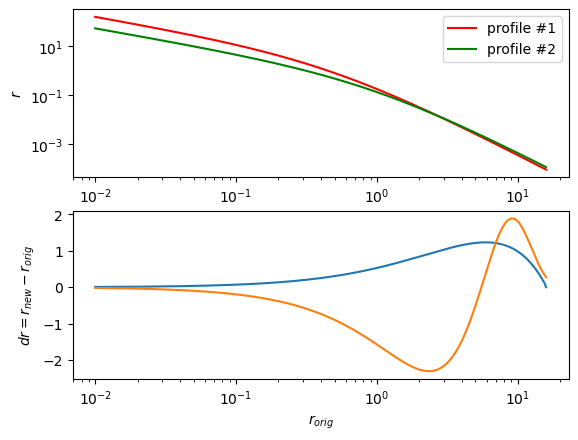

In [33]:
# plot profiles and dr
r = np.logspace(-2, 1.2, 1000)

r_new = icdf2(cdf1(r))
dr = r_new - r

def _function(r, alpha, a, b, c, sigma):
    x = r / sigma
    return alpha * (a/6*x**3 + b/2*x**2 + c*x) * np.exp(-0.5 * x**2)

a = -10
b = 40
c = -20
sigma = 5
alpha = 0.5

fig, axs = plt.subplots(nrows=2, ncols=1)
axs[0].loglog(r, nfw_prof(r, rs1) / compute_nfw_norm(rs1), label="profile #1", color="red")
axs[0].loglog(r, nfw_prof(r, rs2) / compute_nfw_norm(rs2), label="profile #2", color="green")
axs[0].legend(loc="upper right")
axs[0].set_ylabel("$r$")
axs[0].set_xlabel("$p(r)$")

axs[1].semilogx(r, dr)
axs[1].plot(r, _function(r, alpha, a, b, c, sigma))
axs[1].set_ylabel("$dr = r_{new} - r_{orig}$")
axs[1].set_xlabel("$r_{orig}$")


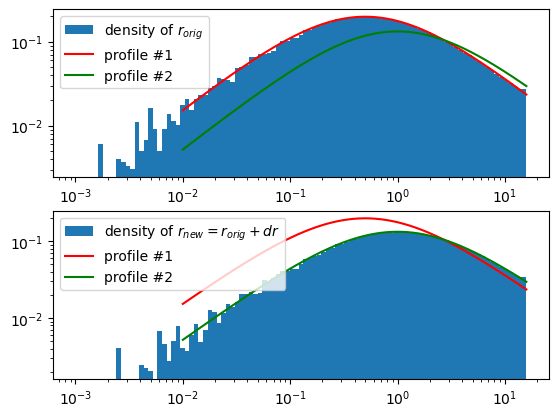

In [36]:
# try it with particles
rng = np.random.RandomState(seed=100)

u = rng.uniform(size=1000000)

r_orig = icdf1(u)

ig, axs = plt.subplots(nrows=2, ncols=1)
axs[0].hist(r_orig, bins=np.logspace(-3, 1.2, 100), log=True, density=True, label="density of $r_{orig}$")
axs[0].plot(r, r*r*nfw_prof(r, rs1) / compute_nfw_norm(rs1), color="red", label="profile #1")
axs[0].plot(r, r*r*nfw_prof(r, rs2) / compute_nfw_norm(rs2), color="green", label="profile #2")
axs[0].set_xscale("log")
axs[0].legend(loc="upper left")

dr = icdf2(cdf1(r_orig)) - r_orig
r_new = r_orig + dr
axs[1].hist(r_new, bins=np.logspace(-3, 1.2, 100), log=True, density=True, label="density of $r_{new} = r_{orig} + dr$")
axs[1].plot(r, r*r*nfw_prof(r, rs1) / compute_nfw_norm(rs1), color="red", label="profile #1")
axs[1].plot(r, r*r*nfw_prof(r, rs2) / compute_nfw_norm(rs2), color="green", label="profile #2")
axs[1].set_xscale("log")
axs[1].legend(loc="upper left")